<a href="https://colab.research.google.com/github/AlexKressner/Business_Intelligence/blob/main/ML_Fallstudie_Online_Barber_Shop_mit_L%C3%B6sung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study "Online Barber Shop"
Sie finden unter `./Daten/Barber/` den Ausschnitt eines Datensatzes einer **Direct-to-Consumer (D2C) Brand**, die über einen Onlineshop **Rasierer** und **Rasierzubehör** verkauft. Für das Unternehmen ist es enorm wichtig, dass es die voraussichtlichen **Absätze der nächsten 21 Tage** kennt, da es Waren im Voraus bei seinen Lieferanten bestellen muss. Je genauer die Absatzprognose, desto weniger Stockouts bzw. unnötige Bestände hat das Unternehmen und desto besser die Marge.

Bisher ist es dem Unternehmen nicht gelungen, gute Prognosen zu erstellen. Um dies zu ändern, werden Sie nun beauftragt, eine Prognose mithilfe von ML-Algorithmen anzufertigen. Dazu stellt Ihnen das Unternehmen einen ersten Datensatz aus seinem Shopsystem zur Verfügung. In diesem sind **3 Produkte** enthalten (Alaunstein, Bartbalm und ein Rasierer) und Sie sollen für diese jeweils eine Absatzprogonse erstellen. Bitte orientieren Sie sich bei der Bearbeitung der Fallstudie an der in diesem Notebook vorgeschlagenen Struktur und greifen Sie auf die Notebooks zurück, die wir bereits in der Vorlesung gemeinsam bearbeitet haben.

Die Struktur Ihres Notebooks sollte dabei wie folgt aussehen und u.a. die folgenden Fragen beantworten:

1. **Daten laden & aufbereiten**. Wichtig: Nachdem Sie die Daten geladen haben, müssen Sie diese zunächst auf Tage und je Produkt aggregieren.
2. **Datenexploration**, d.h. verschaffen Sie sich einen Überblick zum Datensatz. Sie sollten folgende Fragen beantworten:
  - Wie viele Absätze wurden über welchen Zeitraum je Produkt dokumentiert?
  - Was ist der Gesamtumsatz je Produkt?
  - Wie sind die Produktverkäufe im Zeitverlauf? Visualisieren Sie beispielweise die monatlichen/wöchentlichen Verkaufsmengen. Dies ist wichtig, um Trends oder Saisonalität in Zeitreihen zu erkennen.
  - Wie sind die durchschnittlichen Absätze pro Wochentag?
3. **Feature Engineering**
  - Entwickeln Sie basirend auf Ihrer Datenexploration nützliche Features für ein Vorhersagemodell.
  - Stellen Sie sich die Frage, mit welchen Features Sie Saisonalitäten abbilden können. Gibt es Monate in den die Absätze deutlich höher sind? Falls ja, sollten Sie ein Features einführen, das den Monat (Jan, Feb, ..., Dez) abbildet!
  - Bilden Sie autoregressive Features, z.B. könnte es Sinn ergeben zur Progonse des Absatzes an einem Tag (z.B. 15.03.) den Absatz des Vormonats zum gleichen Datum (15.02.) heranzuziehen.
4. **Prognosemodell trainieren und bewerten**
  - Trainieren Sie ein globales Prognosemodell auf allen Daten und bewerten Sie dieses.
  - Trainieren Sie drei lokale Prognosemodelle (für Alaunstein, Bartbalm & Rasierer) und überprüfen Sie, ob die Prognosegüte verbessert wird.


# 1 Daten laden und aufbereiten
Bitte achten Sie hier darauf, dass die Datentypen für die Werte in den Spalten geeignet gewählt sind.

In [1]:
! git clone https://github.com/AlexKressner/Business_Intelligence

Cloning into 'Business_Intelligence'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 298 (delta 98), reused 101 (delta 47), pack-reused 80 (from 1)
Receiving objects: 100% (298/298), 15.59 MiB | 5.38 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [2]:
import pandas as pd

In [3]:
path = "Business_Intelligence/Daten/Barber/"

In [4]:
data = pd.read_csv(path+"barber_shopify_data.csv", sep=";", parse_dates=["Datum"], decimal=",")

In [5]:
data.dtypes

,0
Datum,datetime64[ns]
Produkt,object
Nettomenge,int64
Stueckpreis_brutto,float64
Bruttoumsatz,float64


In [6]:
data.head(10)

,Datum,Produkt,Nettomenge,Stueckpreis_brutto,Bruttoumsatz
0,2020-05-01,Alaunstein,5,8.99,44.949997
1,2020-05-02,Alaunstein,1,8.99,8.990000
2,2020-05-03,Alaunstein,0,8.99,0.000000
3,2020-05-04,Alaunstein,1,9.99,9.990000
4,2020-05-05,Alaunstein,1,9.98,9.980000
5,2020-05-06,Alaunstein,0,9.98,0.000000
6,2020-05-07,Alaunstein,1,9.99,9.990000
7,2020-05-08,Alaunstein,1,9.99,9.990000
8,2020-05-09,Alaunstein,1,9.99,9.990000
9,2020-05-10,Alaunstein,0,9.99,0.000000


#2 Datenaufbereitung
Sie müssen die täglichen Absätze eines Produktes für die nächsten 21 Tage prognostizieren. Die Daten müssen Sie zu diesem Zweck erst aufbereiten. Denken Sie nochmals an das Kapitel, in dem wir Daten gruppiert haben. Die Gruppierung mussen bei dem vorliegenden Problem auf das Datum **und** Produkt erfolgen (tägliche Produktabsätze).

In [7]:
# mit reset_index() sind Datum und Produkt wieder Spalten des DataFrames,
# der nach der Gruppierung resultiert
absatz_tag = data.groupby(["Datum","Produkt"])[["Nettomenge","Bruttoumsatz"]].sum().reset_index()
# absatz_tag = data.groupby(["Datum","Produkt"])[["Nettomenge","Bruttoumsatz"]].sum().reset_index()

In [8]:
absatz_tag.head()

,Datum,Produkt,Nettomenge,Bruttoumsatz
0,2020-05-01,Alaunstein,5,44.949997
1,2020-05-02,Alaunstein,1,8.990000
2,2020-05-03,Alaunstein,0,0.000000
3,2020-05-04,Alaunstein,1,9.990000
4,2020-05-05,Alaunstein,1,9.980000


# 3 Datenexploration und -visualisierung
Verschaffen Sie sich erst einmal einen Überblick zu den Absatzzahlen (für alle drei Produkte summiert oder je Produkt). Visualisieren Sie beispielsweise den Umsatz über den Zeitverlauf. Erkennen Sie Muster, die typisch für den e-Commerce sind? Wie sieht es mit den Produktpreisen aus? Wurden diese überhaupt variiert und haben diese einen Einfluss auf die Absätze? Achten Sie darauf, dass die Spalte "Bruttoumsatz" nicht gleich dem Produktpreis pro Stück ist!

#### Anzahl Beobachtungen

In [9]:
absatz_tag.groupby(["Produkt"])["Nettomenge"].count()

,Nettomenge
Produkt,
Alaunstein,903
Bartbalm Crusoe,720
Rasierer,895


### Umsätze nach Produkt


In [10]:
absatz_tag.groupby(["Produkt"])["Bruttoumsatz"].sum()

,Bruttoumsatz
Produkt,
Alaunstein,38070.136078
Bartbalm Crusoe,14646.310010
Rasierer,217750.595160


### Monatliche Nettomenge (Absatz) der Produkte

In [11]:
# Bedarfe pro Woche über alle drei Produkte
# 1. Schritt: Jahr-Monat aus Spalte Datum ableiten
# "M" bedeutet Monat
absatz_tag["Jahr-Monat"] = absatz_tag["Datum"].dt.to_period("M")

In [12]:
absatz_tag.tail()

,Datum,Produkt,Nettomenge,Bruttoumsatz,Jahr-Monat
2513,2022-10-19,Bartbalm Crusoe,1,19.990000,2022-10
2514,2022-10-19,Rasierer,7,244.930010,2022-10
2515,2022-10-20,Alaunstein,5,49.949997,2022-10
2516,2022-10-20,Bartbalm Crusoe,1,19.990000,2022-10
2517,2022-10-20,Rasierer,3,104.960010,2022-10


In [13]:
# 2. Schritt: Bruttoumsatz auf Monatsscheiben aggregieren
monatsumsaetze = absatz_tag.groupby(["Produkt","Jahr-Monat"])["Nettomenge"].sum().reset_index()

<Axes: title={'center': 'Bruttoumsatz Alaunstein'}, xlabel='Jahr-Monat', ylabel='Nettomenge [Stk.]'>

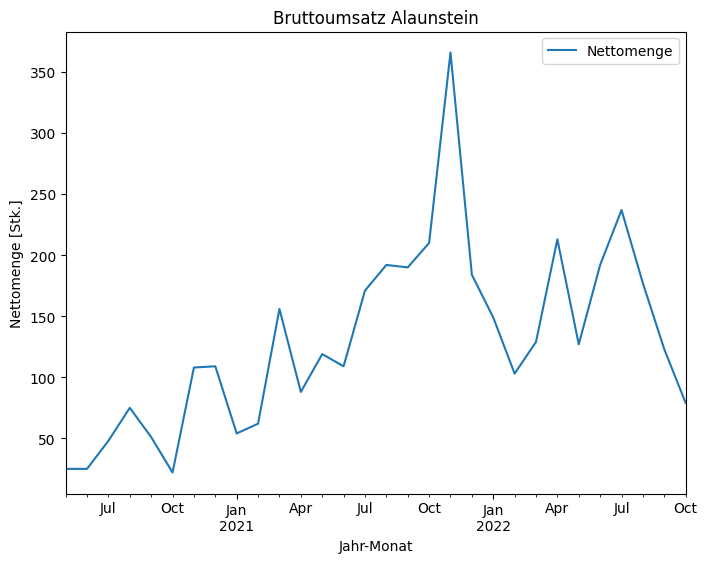

In [14]:
# 3. Schritt: Bruttoumsatz eines Produktes abbilden
monatsumsaetze[monatsumsaetze.Produkt=="Alaunstein"].plot(kind="line",
                                                          x="Jahr-Monat",
                                                          y="Nettomenge",
                                                          figsize=(8,6),
                                                          title="Bruttoumsatz Alaunstein",
                                                          ylabel="Nettomenge [Stk.]")

<Axes: title={'center': 'Bartbalm Crusoe'}, xlabel='Jahr-Monat'>

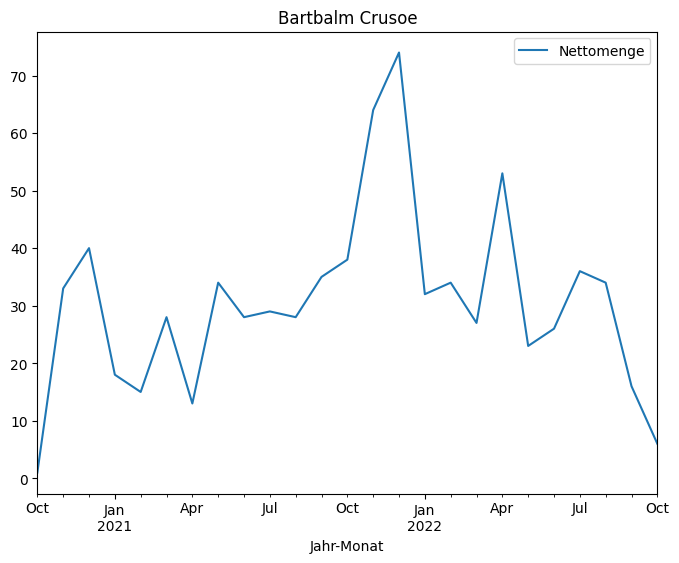

In [15]:
monatsumsaetze[monatsumsaetze.Produkt=="Bartbalm Crusoe"].plot(kind="line", x="Jahr-Monat", y="Nettomenge", figsize=(8,6), title="Bartbalm Crusoe")

#### Darstellung der Nettomengen je Produkt in einer Abbildung

In [16]:
import matplotlib.pyplot as plt
# alle Bruttoumsätze in einer Abbildung
# 1. Schritt: Spalte zum Index machen (x-Achse)
monatsumsaetze.set_index("Jahr-Monat", inplace=True)

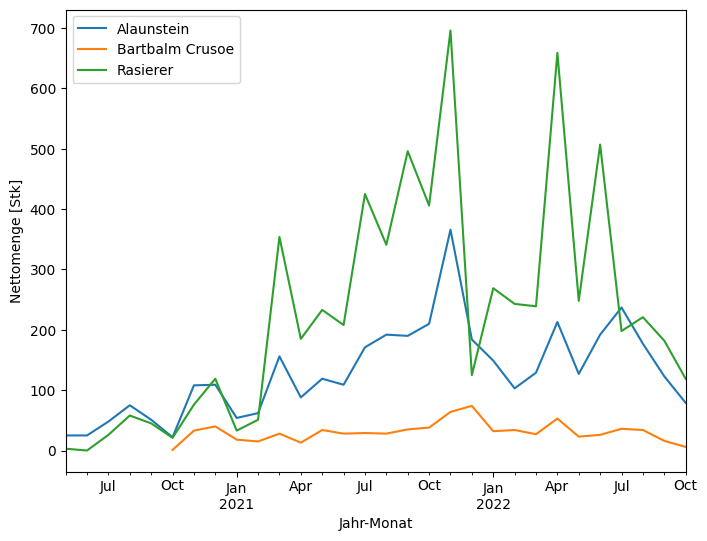

In [17]:
# 2. Schritt: Erzeugen des Abbildungsobjektes
fig, ax = plt.subplots(figsize=(8,6))
# 3. Schritt: Jeweiliges gruppieren auf Produkte und Übergabe des Abbildungsobjektes "ax=ax"
for label, df in monatsumsaetze.groupby('Produkt'):
    df["Nettomenge"].plot(
        kind="line",
        ax=ax,
        label=label,
        ylabel="Nettomenge [Stk]"
        )
plt.legend()

### Umsatz und Nettomenge

#### Nach Monat

In [18]:
absatz_tag["Monat"] = absatz_tag.Datum.dt.month

<Axes: xlabel='Monat'>

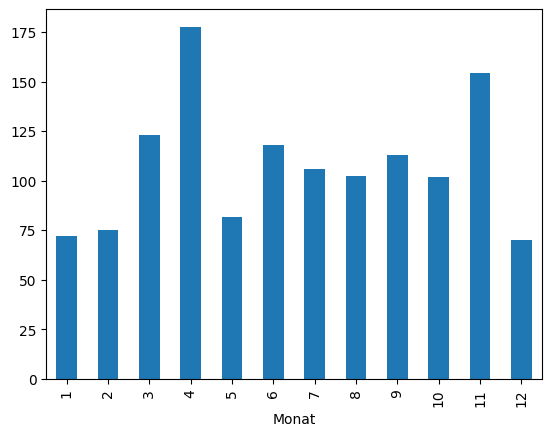

In [19]:
absatz_tag.groupby("Monat")["Bruttoumsatz"].mean().plot(kind = "bar")

<Axes: xlabel='Monat'>

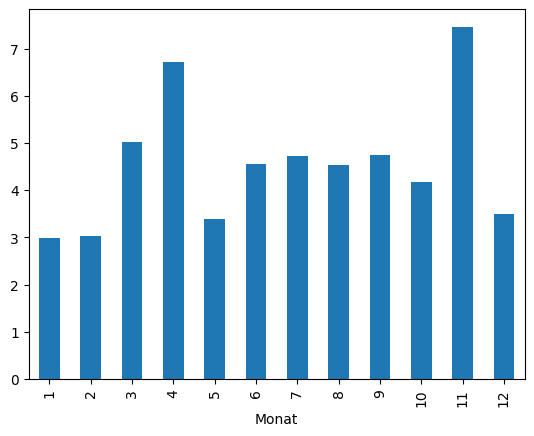

In [20]:
absatz_tag.groupby("Monat")["Nettomenge"].mean().plot(kind = "bar")

#### Nach Woche

In [21]:
absatz_tag["Woche"] = absatz_tag.Datum.dt.isocalendar().week

<Axes: xlabel='Woche'>

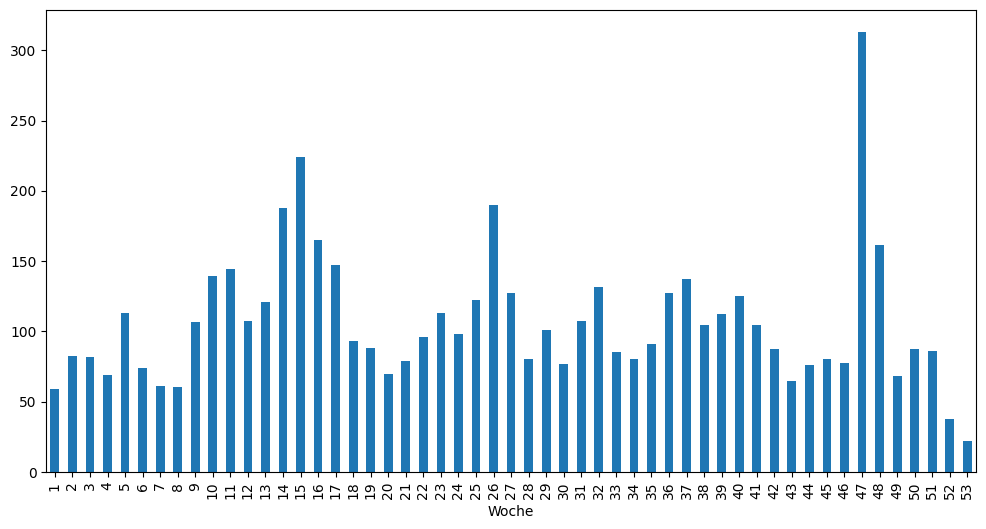

In [22]:
absatz_tag.groupby("Woche")["Bruttoumsatz"].mean().plot(kind = "bar", figsize=(12,6))

<Axes: xlabel='Woche'>

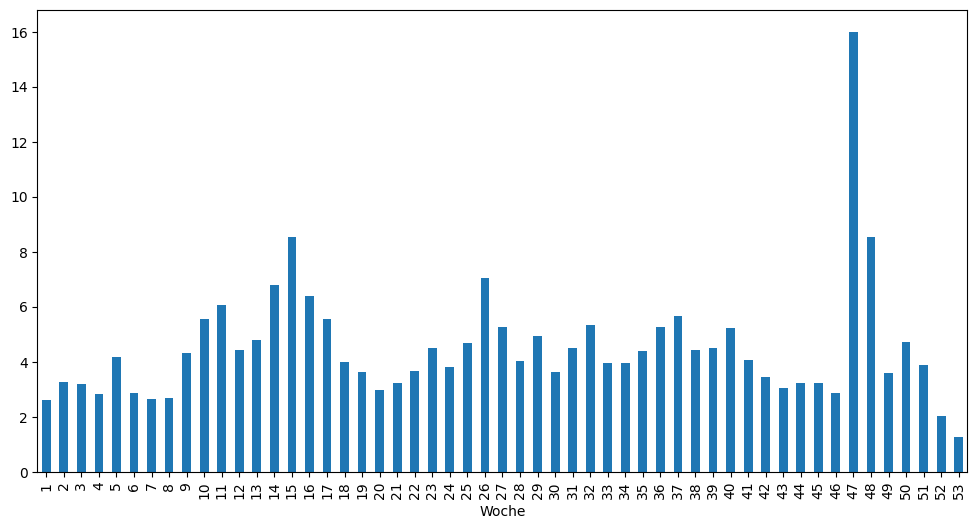

In [23]:
absatz_tag.groupby("Woche")["Nettomenge"].mean().plot(kind = "bar", figsize=(12,6))

#### Nach Wochentag

In [24]:
absatz_tag["Wochentag"] = absatz_tag.Datum.dt.weekday

<Axes: xlabel='Wochentag'>

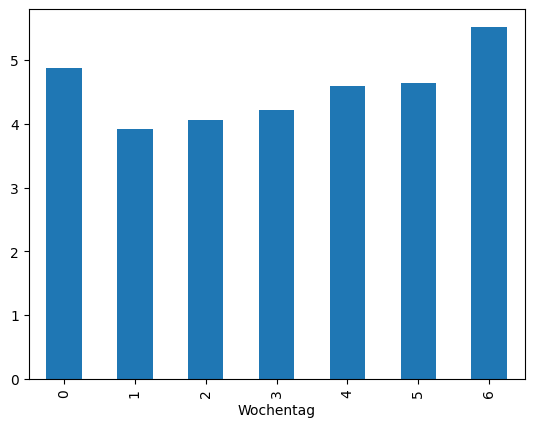

In [25]:
absatz_tag.groupby("Wochentag")["Nettomenge"].mean().plot(kind = "bar")

### Stückpreis und Absatz nach Woche

In [26]:
absatz_tag["Stueckpreis"] = absatz_tag["Bruttoumsatz"] / absatz_tag["Nettomenge"]

In [27]:
absatz_tag["Jahr-Woche"] = absatz_tag["Datum"].dt.to_period("W")

In [28]:
absatz_tag.Produkt.unique()

array(['Alaunstein', 'Rasierer', 'Bartbalm Crusoe'], dtype=object)

In [29]:
produkt = "Alaunstein"

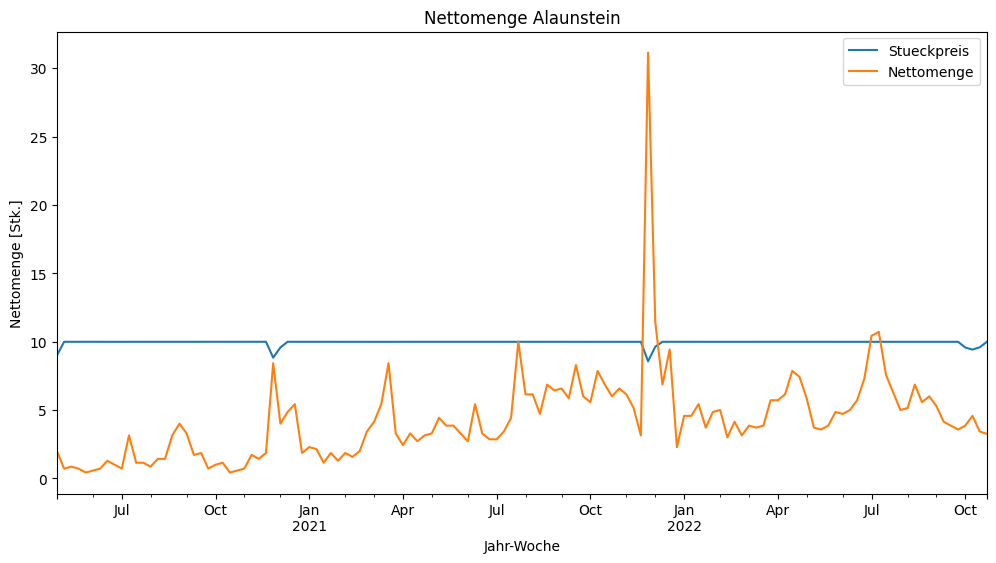

In [30]:
fig, ax = plt.subplots(figsize=(12,6))
# Abbildung zum Preis
absatz_tag[absatz_tag.Produkt==produkt].groupby("Jahr-Woche")["Stueckpreis"].mean().plot(kind="line", ax=ax)
# Abbildung zur Nettomenge
absatz_tag[absatz_tag.Produkt==produkt].groupby("Jahr-Woche")["Nettomenge"].mean().plot(kind="line", ax=ax, title=f"Nettomenge {produkt}", ylabel="Nettomenge [Stk.]")
plt.legend()

# 4 Feature Engineering
Beim Feature Engineering versucht man weitere Merkmale aus den gegebenen Grunddaten abzuleiten, die bei der Prognose hilfreich sein können. Im vorliegenden Fall bietet es sich beispielsweise an **zeitlichen** und **preislichen Features** abzuleiten.

**Zeitliche Features**: Zum Beispiel können wir aus dem Datum die Woche oder den Monat entnehmen. Dies ergibt Sinn, wenn wir vermuten, dass der Monat/ die Woche einen Einfluss auf die Höhe der Absätze hat. Ebenso vorstellbar ist es, eine Trendvariable einzuführen, die das durchschnittlicher Absatzwachstum des Shops über die Zeit erfasst.

**Preisliche Features**: Wir sollten vermutlich den Produktpreis als Feature verwenden. Außerdem könnte es interessant sein, den durchschnittlichen Produktpreis der letzten x-Wochen als Feature zu berücksichtigen, oder die individuellen Preise der letzten x-Wochen.

In [31]:
data.dtypes

,0
Datum,datetime64[ns]
Produkt,object
Nettomenge,int64
Stueckpreis_brutto,float64
Bruttoumsatz,float64


In [32]:
# Einfaches Feature Engineering
data["Wochentag"] = data["Datum"].dt.dayofweek
data["Monat"] = data["Datum"].dt.month
data["Woche"] = data["Datum"].dt.isocalendar().week
data["Stueckpreis"] = data["Bruttoumsatz"] / data["Nettomenge"]
data.tail()

,Datum,Produkt,Nettomenge,Stueckpreis_brutto,Bruttoumsatz,Wochentag,Monat,Woche,Stueckpreis
2513,2022-10-16,Bartbalm Crusoe,0,19.99,0.00,6,10,41,NaN
2514,2022-10-17,Bartbalm Crusoe,0,19.99,0.00,0,10,42,NaN
2515,2022-10-18,Bartbalm Crusoe,0,19.99,0.00,1,10,42,NaN
2516,2022-10-19,Bartbalm Crusoe,1,19.99,19.99,2,10,42,19.99
2517,2022-10-20,Bartbalm Crusoe,1,19.99,19.99,3,10,42,19.99


In [33]:
# Nicht-verfügbare Preise "nach vorne" auffüllen (forward-fill = ffill)
data.sort_values(by=["Produkt","Datum"], inplace=True)
data['Stueckpreis'] = data.groupby('Produkt')['Stueckpreis'].ffill()

In [34]:
# Weitere preisliche Features (wir nehmen an, dass es eine Preisplanung gibt, wenn wir die Prognose machen)

# Wie ist der aktuelle Preis im Vergleich zum Median-Preis
absatz_tag["Preismomentum"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.median() - x)

# Haben die Preise der letzten Tage einen Einfluss auf die aktuelle Nachfrage?
absatz_tag["Preis_shift_1"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.shift(1))
absatz_tag["Preis_shift_2"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.shift(2))
absatz_tag["Preis_shift_3"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.shift(3))
absatz_tag["Preis_shift_4"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.shift(4))
absatz_tag["Preis_shift_5"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.shift(5))

# es gäbe noch viele weitere Features

In [35]:
absatz_tag[absatz_tag.Produkt=="Alaunstein"].tail()

,Datum,Produkt,Nettomenge,Bruttoumsatz,Jahr-Monat,Monat,Woche,Wochentag,Stueckpreis,Jahr-Woche,Preismomentum,Preis_shift_1,Preis_shift_2,Preis_shift_3,Preis_shift_4,Preis_shift_5
2503,2022-10-16,Alaunstein,5,39.960000,2022-10,10,41,6,7.992000,2022-10-10/2022-10-16,1.996571,9.986667,NaN,NaN,9.980000,9.986667
2506,2022-10-17,Alaunstein,5,49.930000,2022-10,10,42,0,9.986000,2022-10-17/2022-10-23,0.002571,7.992000,9.986667,NaN,NaN,9.980000
2509,2022-10-18,Alaunstein,2,19.970000,2022-10,10,42,1,9.985000,2022-10-17/2022-10-23,0.003571,9.986000,7.992000,9.986667,NaN,NaN
2512,2022-10-19,Alaunstein,1,9.990000,2022-10,10,42,2,9.990000,2022-10-17/2022-10-23,-0.001429,9.985000,9.986000,7.992000,9.986667,NaN
2515,2022-10-20,Alaunstein,5,49.949997,2022-10,10,42,3,9.989999,2022-10-17/2022-10-23,-0.001428,9.990000,9.985000,9.986000,7.992000,9.986667


In [36]:
absatz_tag.dropna(inplace=True)

In [37]:
absatz_tag.groupby("Produkt")["Datum"].count()

,Datum
Produkt,
Alaunstein,584
Bartbalm Crusoe,77
Rasierer,558


In [38]:
absatz_tag.Produkt.unique()

array(['Alaunstein', 'Rasierer', 'Bartbalm Crusoe'], dtype=object)

In [39]:
absatz_tag.columns

Index(['Datum', 'Produkt', 'Nettomenge', 'Bruttoumsatz', 'Jahr-Monat', 'Monat',
       'Woche', 'Wochentag', 'Stueckpreis', 'Jahr-Woche', 'Preismomentum',
       'Preis_shift_1', 'Preis_shift_2', 'Preis_shift_3', 'Preis_shift_4',
       'Preis_shift_5'],
      dtype='object')

In [40]:
FEATURES = [
    "Produkt","Monat","Woche","Wochentag", "Stueckpreis",
    'Preismomentum', 'Preis_shift_1', 'Preis_shift_2', 'Preis_shift_3',
    'Preis_shift_4', 'Preis_shift_5'
    ]

In [41]:
TARGET = "Nettomenge"

# 5 Prognosemodell trainieren und bewerten
Versuchen Sie ein Modell auf die Daten zu trainieren. Testen Sie verschiedene Modellparameter mithilfe einer Grid Search und Cross-Validation.

### 5.1 Produkte als Feature (Ein Prognosemodell für alle Produkte)

In [42]:
# Features und target
X = absatz_tag.set_index("Produkt", drop=False)[FEATURES]
y = absatz_tag.set_index("Produkt", drop=False)[TARGET]

In [43]:
X = pd.get_dummies(X)

In [44]:
X.tail()

,Monat,Woche,Wochentag,Stueckpreis,Preismomentum,Preis_shift_1,Preis_shift_2,Preis_shift_3,Preis_shift_4,Preis_shift_5,Produkt_Alaunstein,Produkt_Bartbalm Crusoe,Produkt_Rasierer
Produkt,,,,,,,,,,,,,
Rasierer,10,42,0,34.990000,-5.000000,34.990000,34.990,34.990,34.990,34.990002,False,False,True
Rasierer,10,42,1,34.990000,-5.000000,34.990000,34.990,34.990,34.990,34.990000,False,False,True
Rasierer,10,42,2,34.990001,-5.000001,34.990000,34.990,34.990,34.990,34.990000,False,False,True
Alaunstein,10,42,3,9.989999,-0.001428,9.990000,9.985,9.986,7.992,9.986667,True,False,False
Rasierer,10,42,3,34.986670,-4.996670,34.990001,34.990,34.990,34.990,34.990000,False,False,True


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.model_selection import GridSearchCV

In [46]:
# Grid definieren
param_grid = {
    "n_estimators": [50, 150, 250, 500] # Anzahl der Entscheidungsbäume
}

In [47]:
PRODUKTE = absatz_tag.Produkt.unique()
PRODUKTE

array(['Alaunstein', 'Rasierer', 'Bartbalm Crusoe'], dtype=object)

In [48]:
ergebnis = {}
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
# Modell auswählen und trainieren
model = RandomForestRegressor()
grid = GridSearchCV(
    model, # verwendetes Modell
    param_grid, # zu untersuchende Parameter
    cv=10, # Anzahl der Folds
    n_jobs=-1, # Parallelisierung der Ausführung
    scoring="neg_mean_squared_error", # Fehlermaß
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
# Modell evaluieren
for produkt in PRODUKTE:
  # Prognosen machen (y_pred)
  y_pred = best_model.predict(X_test.loc[produkt])
  ergebnis[produkt] = sklearn.metrics.mean_absolute_error(y_test.loc[produkt], y_pred)
print(ergebnis)

{'Alaunstein': 1.852307692307692, 'Rasierer': 2.7628928571428566, 'Bartbalm Crusoe': 1.3168000000000002}


### 5.2. Ein Modell je Produkt

In [49]:
ergebnis = {}
for produkt in PRODUKTE:
  X = absatz_tag.loc[absatz_tag.Produkt==produkt, FEATURES].drop(columns=["Produkt"])
  y = absatz_tag.loc[absatz_tag.Produkt==produkt, TARGET]
  X = pd.get_dummies(X)

  # Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
  # Modell auswählen und trainieren
  model = RandomForestRegressor()
  grid = GridSearchCV(
      model, # verwendetes Modell
      param_grid, # zu untersuchende Parameter
      cv=10, # Anzahl der Folds
      n_jobs=-1, # Parallelisierung der Ausführung
      scoring="neg_mean_squared_error", # Fehlermaß
  )
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  # Prognosen machen (y_pred)
  y_pred = best_model.predict(X_test)
  # Modell evaluieren
  ergebnis[produkt] = sklearn.metrics.mean_absolute_error(y_test, y_pred)

In [50]:
ergebnis

{'Alaunstein': 2.3323760683760675,
 'Rasierer': 3.810297619047619,
 'Bartbalm Crusoe': 1.0117500000000001}

# 6 Prognosemodell unter Berücksichtigung der Zeitreiheneigenschaft (korrektes Vorgehen)

In [51]:
absatz_tag.sort_values(by="Datum", inplace=True)

In [52]:
PROGNOSEHORIZONT = 21 # Prognose für die nächsten 21 Tage

In [53]:
from sklearn.model_selection import TimeSeriesSplit

In [54]:
import numpy as np

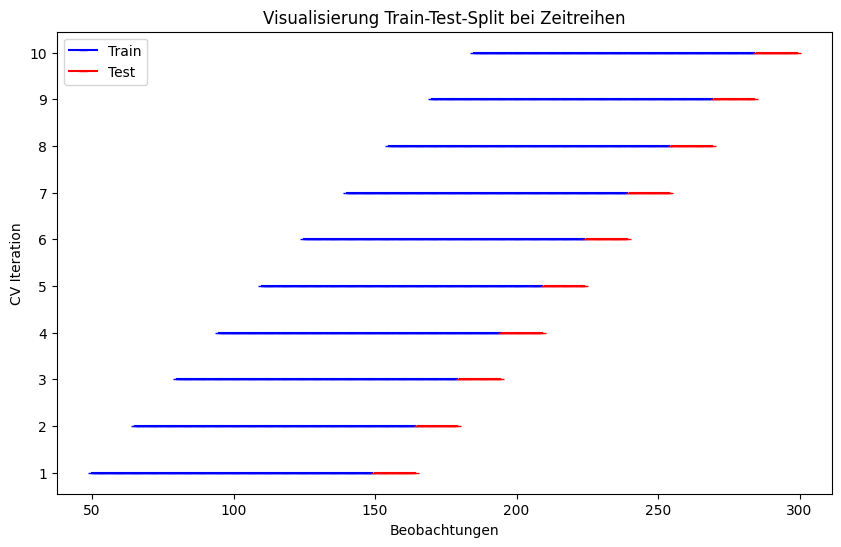

In [55]:
# Veranschaulichung Train-Test-Split bei Zeitreihen
X = absatz_tag["Nettomenge"].head(300)

# Define the number of splits for TimeSeriesSplit
n_splits = 10
tscv = TimeSeriesSplit(
    n_splits=n_splits,
    max_train_size = 100,
    test_size=15)

plt.figure(figsize=(10, 6))

for i, (train, test) in enumerate(tscv.split(X), start=1):
    plt.plot(train, [i] * len(train), marker='_', linewidth=1.5, color="blue", label = "Train" if i==n_splits else None)
    plt.plot(test, [i] * len(test), marker='_', linewidth=1.5, color='red', label = "Test" if i==n_splits else None)

plt.legend()
plt.xlabel('Beobachtungen')
plt.ylabel('CV Iteration')
plt.title('Visualisierung Train-Test-Split bei Zeitreihen')
plt.yticks(range(1, n_splits + 1))
plt.show()

In [56]:
ergebnis = {}
for produkt in PRODUKTE:
  # 1. Schritt: Daten auf Produkt filtern
  X = absatz_tag.loc[absatz_tag.Produkt==produkt, FEATURES].drop(columns="Produkt")
  y = absatz_tag.loc[absatz_tag.Produkt==produkt, TARGET]

  # 2. Schritt: Daten umwandeln
  X = pd.get_dummies(X)

  # 3. Schritt: Zeitlicher Split (Prognose für die nächsten 21 Tage)
  X_train = X[:-PROGNOSEHORIZONT]
  y_train = y[:-PROGNOSEHORIZONT]
  X_test = X[-PROGNOSEHORIZONT:]
  y_test = y[-PROGNOSEHORIZONT:]

  # 4. Split für Cross-Validation
  n_splits = 5
  tscv = TimeSeriesSplit(
      n_splits=n_splits,
      #test_size=PROGNOSEHORIZONT
      )

  # Modell auswählen und trainieren
  model = RandomForestRegressor()
  grid = GridSearchCV(
      model, # verwendetes Modell
      param_grid, # zu untersuchende Parameter
      cv=tscv, # Anzahl der Folds
      n_jobs=-1, # Parallelisierung der Ausführung
      scoring="neg_mean_squared_error", # Fehlermaß
  )
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  # Prognosen machen (y_pred)
  y_pred = best_model.predict(X_test)
  # Ergebnisse für 21 Tage Nettomenge summiert
  ergebnis[produkt] = sklearn.metrics.mean_absolute_error(y_test, y_pred)

In [57]:
ergebnis

{'Alaunstein': 3.71447619047619,
 'Rasierer': 4.065809523809524,
 'Bartbalm Crusoe': 1.0476190476190477}